In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.metrics import classification_report
from imblearn.combine import SMOTETomek
from sklearn import metrics
from textblob import TextBlob, Word
from imblearn.over_sampling import SMOTE
from pactools.grid_search import GridSearchCVProgressBar
from sklearn.metrics import accuracy_score

import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

pd.set_option('max_colwidth', 9999)

%matplotlib inline

In [6]:
df = pd.read_csv('clean.csv')

In [7]:
df.shape

(26000, 3)

In [8]:
df.message.isnull().sum()

26

In [9]:
df.duplicated().sum()

188

In [10]:
df = df.dropna()
df = df.drop_duplicates()

In [11]:
df = df[df['genre'] == 'direct']

In [12]:
df.shape

(10475, 3)

In [13]:
df['related'].value_counts(normalize=True)

1    0.678091
0    0.321909
Name: related, dtype: float64

In [14]:
X = df['message']
y = df['related']
tv = TfidfVectorizer()

In [15]:
print(X.shape)
print(y.shape)

(10475,)
(10475,)


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [17]:
X_train = tv.fit_transform(X_train)
X_test = tv.transform(X_test)

/anaconda3/lib/python3.6/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


In [18]:
sm = SMOTETomek(random_state=42)
X_res, y_res = sm.fit_sample(X_train, y_train)

In [17]:
print(X_res.shape)
print(y_res.shape)

(10564, 9108)
(10564,)


In [18]:
def gridsearch_summary(X_train, X_test, y_train, y_test, model_name, model, model_params, problem = 'classification'):
    '''
    Arguments:
    X_train, X_test, y_train, y_test : vectorized train test split of X and y
    model_name : str name of model
    model : model constructor
        example: 'LogisticRegression' : LogisticRegression()
    model_params : dictionary of param_grids for GridSearch
        example: 'LogisticRegression' : {
                      'penalty' : ['l1', 'l2'],
                      'C' : [.1, 1, 10] }
    problem : str of problem type: 'classification' or 'regression'
    
    Return:
    summary_df : a single row DataFrame containing the GridSearch model and its 
              best model, predictions, and scores.
    '''   
    problem = problem.lower()
    
    if problem != 'regression' and problem != 'classification':
        print('Invalid problem type. Try "regression" or "classification"')
        return

    summary = {}

    # Track progress
    print(f'Fitting {model_name}')

    # GridSearch
    gs = GridSearchCVProgressBar(model, model_params, cv = 5, n_jobs = -1)
    gs.fit(X_train, y_train)

    # Make predictions
    y_train_pred = gs.best_estimator_.predict(X_train)
    y_test_pred = gs.best_estimator_.predict(X_test)

    # Build summary
    summary['Model Name'] = model_name
    summary['Train Pred'] = y_train_pred
    summary['Test Pred'] = y_test_pred
    summary['Best Score'] = gs.best_score_
    summary['Best Params'] = gs.best_params_
    summary['Best Estimator'] = gs.best_estimator_
    summary['Grid Search Model'] = gs

    if problem == 'regression':
        summary['Train Score'] = r2_score(y_train, y_train_pred)
        summary['Test Score'] = r2_score(y_test, y_test_pred)
    elif problem == 'classification':
        summary['Train Score'] = accuracy_score(y_train, y_train_pred)
        summary['Test Score'] = accuracy_score(y_test, y_test_pred)
    
    # Construct output dataframe 
    summary_df = pd.DataFrame([summary])

    # Rearrange columns
    summary_df = summary_df[['Model Name', 'Best Params', 'Best Score', 'Best Estimator',
                             'Train Score', 'Test Score', 'Train Pred', 'Test Pred', 'Grid Search Model']]
        
    return summary_df

In [19]:
classifier_models = {
    'LogisticRegression' : LogisticRegression(random_state = 42, n_jobs = -1),
    'KNN': KNeighborsClassifier(), 
    'NaiveBayes' : MultinomialNB(),
    'DecisionTree' : DecisionTreeClassifier(random_state = 42), 
    'BaggedDecisionTree' : BaggingClassifier(random_state = 42, n_jobs = -1),
    'RandomForest' : RandomForestClassifier(random_state = 42, n_jobs = -1), 
    'ExtraTrees' : ExtraTreesClassifier(random_state = 42, n_jobs = -1), 
    'AdaBoost' : AdaBoostClassifier(random_state=42), 
    'GradientBoosting' : GradientBoostingClassifier(random_state = 42),
    'SVM' : SVC(random_state=42),
    'XGBoost' : XGBClassifier(random_state=42, n_jobs = -1)
}

In [20]:
classifier_model_params = {
    'LogisticRegression' : {
        'penalty' : ['l1', 'l2'],
        'C' : np.arange(.05, 1, .05) },
    'KNN' : {
        'n_neighbors' : np.arange(3, 22, 2) },
    'NaiveBayes' : {
        'alpha' : np.arange(.05, 2, .05)},
    'DecisionTree': {
        'max_depth' : [ 6, 10, 14], 
        'min_samples_leaf' : [1, 2],
        'min_samples_split': [2, 3] },
    'BaggedDecisionTree' : {
        'n_estimators' : [20, 60, 100] },
    'RandomForest' : {
        'n_estimators' : [20, 60, 100],
        'max_depth' : [ 2, 6, 10],
        'min_samples_split' : [2, 3, 4] },
    'ExtraTrees' : {
        'n_estimators' : [20, 60, 100],
        'max_depth' : [ 6, 10, 14],
        'min_samples_leaf' : [1, 2], 
        'min_samples_split' : [2, 3], },
    'AdaBoost' : {
        'n_estimators' : np.arange(100, 151, 25),
        'learning_rate' : np.linspace(0.05, 1, 20) },
    'GradientBoosting' : {
        'n_estimators' : np.arange(5, 150, 10),
        'learning_rate' : np.linspace(0.05, 1, 20),
        'max_depth' : [1, 2, 3] },
    'SVM' : {
        'C' : np.arange(0.05, 1, .05),
        'kernel' : ['rbf', 'linear'] },
    'XGBoost' : {
        'n_estimators'  : np.arange(100, 151, 25), 
        'learning_rate' : np.arange(0.1, 1, .3),
        'max_depth' : [3],
        'alpha' : np.arange(0, 1, .3),
        'lambda' : np.arange(0, 1, .3),
        'gamma' : np.arange(0, 1, .3),
        'subsample' : [.5],
        }
}

In [21]:
gs_summaries = pd.DataFrame()

In [39]:
gs_summaries[['Model Name', 'Best Params', 'Best Score', 'Train Score', 'Test Score']].sort_values(by ='Best Score')

,Model Name,Best Params,Best Score,Train Score,Test Score
2,BaggedDecisionTree,{'n_estimators': 100},0.790585,0.996022,0.723177
1,DecisionTree,"{'max_depth': 14, 'min_samples_leaf': 1, 'min_samples_split': 2}",0.795226,0.818053,0.740359
3,RandomForest,"{'max_depth': 10, 'min_samples_split': 3, 'n_estimators': 100}",0.805266,0.819189,0.743414
4,ExtraTrees,"{'max_depth': 14, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}",0.807066,0.840027,0.753723
6,XGBoost,"{'alpha': 0.0, 'gamma': 0.3, 'lambda': 0.0, 'learning_rate': 0.4, 'max_depth': 3, 'n_estimators': 125, 'subsample': 0.5}",0.833491,0.861053,0.796487
5,AdaBoost,"{'learning_rate': 0.75, 'n_estimators': 150}",0.835291,0.857928,0.796869
0,LogisticRegression,"{'C': 0.8500000000000001, 'penalty': 'l1'}",0.840500,0.888710,0.810997


0.8350056796667928
0.7926689576174112
              precision    recall  f1-score   support

           0       0.64      0.82      0.72       843
           1       0.90      0.78      0.84      1776

   micro avg       0.79      0.79      0.79      2619
   macro avg       0.77      0.80      0.78      2619
weighted avg       0.82      0.79      0.80      2619



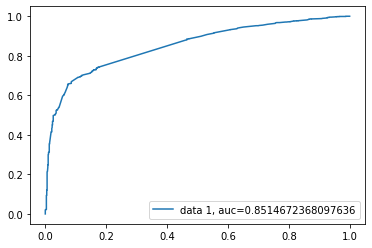

CPU times: user 14.3 s, sys: 61.4 ms, total: 14.4 s
Wall time: 14.4 s


In [39]:
%%time
logpipe = Pipeline([('tfidf', TfidfTransformer()),
                    ('ad', AdaBoostClassifier(learning_rate = 0.75, n_estimators = 150))])
# Fit your model
logpipe.fit(X_res, y_res)

# Training score
print(logpipe.score(X_res, y_res))
# Test score
print(logpipe.score(X_test, y_test))

y_pred = logpipe.predict(X_test)

print(classification_report(y_test,y_pred))
ad = AdaBoostClassifier()

ad.fit(X_res, y_res)
y_pred = ad.predict(X_test)

y_pred_proba = ad.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [64]:
from sklearn.externals import joblib
joblib.dump(logpipe,'model2.joblib')
joblib.dump(tv,'tv.joblib')

['tv.joblib']